# 第8週：China FUD twitter相關推文之詞彙關係

Author: 蘇舫萱  
Date created: 2021/09/  
Last modified: 2020/09/  
本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。在這個Jupyter Notebook中將會以twitter上China FUD議題推文做為分析資料。


> **事件介紹**  
**9/24**  
中國人民銀行在官網上明確指出加密或幣相關交易將會被視為是「非法金融活動」，也會制止任何挖礦行為，是中國對幣圈迄今最嚴厲且全面的措施。

> **FUD（Fear, Uncertainty, and Doubt；恐懼、不確定性和懷疑）**  
是幣圈術語，也就是投資者對未知的前景和負面消息感到恐懼的意思。  
FUD 主要是散佈關於某些事物的任何虛假資訊、從而誤導大眾，甚至因此令資產價格因為虛假或錯誤資訊而下跌。  
所以，中國封殺比特幣就被稱為「China FUD」。

## 大綱

- 1. 套件說明
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
- 3. TF-IDF
    - 3.1 計算每篇文章的詞數
    - 3.2 合併需要的資料欄位
    - 3.3 計算tf-idf值
    - 3.4 檢視結果
- 4. 斷詞與N-gram
    - 4.1 Bigram
    - 4.2 Trigram
- 5. 建立Ngram預測模型
- 6. Bigram視覺化
- 7. Pairwise correlation
    - 7.1 找出相關性高的詞彙
    - 7.2 畫出關係圖
- 8. 計算文章相似度

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。

- math: 數學運算工具。
- collections: 提供額外的數據類型。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer,TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [1]:
# pip install -U networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import nltk
#nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

## 2. 資料前處理

### 2.1 基本資料介紹
- 資料來源: twitter 2021-09-24 ~ 2021-09-25文章
- 資料集： tweets.csv
- 關鍵字：China FUD
- 資料時間：2021-09-24 ~ 2021-09-25
- 資料筆數：共 3000 篇文章

In [3]:
#匯入資料
MetaData = pd.read_csv('./raw_data/tweets2.csv')

In [4]:
MetaData.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,@cryptan48665041 @tomskiweb FUD. Same old Chin...,0,0,Twitter for iPhone
1,2021-09-25 08:51:57,1441686903204585472,CatherineMugari,Cathy mugs,@IOHK_Charles China is buying thr own FUD nxaa,0,0,Twitter for Android
2,2021-09-25 08:51:52,1441686880240783360,TheReal_KDubb,K Dubb,Bitcoin Maintains $42K Amid the China FUD: Car...,0,0,Twitter Web App


In [5]:
#增加ID
MetaData = MetaData.assign(art_id = MetaData.index)

### 2.2 資料清理  
- 去除特殊字元與標點符號

In [6]:
def clean(row): 
    text = re.sub('[\t]{2,}', '', row) #去除兩個以上空格或tab
    text = re.sub('(http|https)://.*', '', text) #去除網址(.:任意字元，*:0次以上)
    text = re.sub('&.*;', '', text) #去除html特殊字元編碼
    text = re.sub('#_*', '', text) #去除一個或多個_
    text = re.sub('\\n', ' ', text) #去除換行
    text = re.sub('\.|,', ' ', text) #替代.,
    text = re.sub('\s{2,}', ' ', text) #去除多個空格(+:一次以上)
    text = re.sub('^\\s+|\\s+$', '', text) #去除開頭/結尾有一個或多個空格
    text = re.sub('[^a-zA-Z ]', '', text) #除了字母,空白?!.的都去掉(表情符號去掉)
    return text

In [7]:
MetaData['text'] = MetaData.text.apply(clean)
MetaData.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0
1,2021-09-25 08:51:57,1441686903204585472,CatherineMugari,Cathy mugs,IOHKCharles China is buying thr own FUD nxaa,0,0,Twitter for Android,1
2,2021-09-25 08:51:52,1441686880240783360,TheReal_KDubb,K Dubb,Bitcoin Maintains K Amid the China FUD Cardano...,0,0,Twitter Web App,2


### 2.3 文章斷詞與整理

In [8]:
##新增stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/skypc785308/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# 設定斷詞 function
stemmer = PorterStemmer() #做Stemming還原詞幹
def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    return seg_list

In [10]:
data = MetaData.copy()
data['word'] = data.text.apply(getToken)
data = data.explode('word')
data.reset_index(inplace=True, drop=True) #重設index
data.head()

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan
1,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb
2,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud
3,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,old
4,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,china


In [11]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(["art_id","word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [12]:
word_count

,art_id,word,count
0,0,ban,1
1,0,china,1
2,0,crackdown,1
3,0,cryptan,1
4,0,crypto,1
...,...,...,...
27725,2999,im,1
27726,2999,issu,1
27727,2999,li,1
27728,2999,press,1


## 3. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
### 3.1 計算每篇文章的詞數

In [13]:
total_words = data.groupby(['art_id'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,art_id,total
0,0,13
1,1,6
2,2,11
3,3,7
4,4,10
...,...,...
2995,2995,9
2996,2996,12
2997,2997,6
2998,2998,6


### 3.2 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [14]:
fud_words = word_count.merge(total_words,on = 'art_id',how = 'left')
fud_words.head(10)

,art_id,word,count,total
0,0,ban,1,13
1,0,china,1,13
2,0,crackdown,1,13
3,0,cryptan,1,13
4,0,crypto,1,13
5,0,fail,1,13
6,0,fud,1,13
7,0,news,1,13
8,0,old,1,13
9,0,tomskiweb,1,13


### 3.3 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。  
        詞彙在該文件中出現次數 / 該文件中詞彙總數  
    - IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log  
        log( 總文件數量 / 包含該詞彙的文件數量 ) 

In [15]:
#計算tf
fud_words_tf_idf = fud_words.assign(tf = fud_words.iloc[:,2]/fud_words.iloc[:,3])

In [16]:
# 計算每個詞彙出現在幾篇文章中
idf_df = fud_words.groupby(['word'],as_index=False).size()
fud_words_tf_idf = fud_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [17]:
#計算idf
fud_words_tf_idf = fud_words_tf_idf.assign(idf = fud_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

fud_words_tf_idf = fud_words_tf_idf.drop(labels=['size'],axis=1)

In [18]:
#計算tf*idf
fud_words_tf_idf = fud_words_tf_idf.assign(tf_idf = fud_words_tf_idf.iloc[:,4]*fud_words_tf_idf.iloc[:,5])

In [19]:
fud_words_tf_idf.head(10)

,art_id,word,count,total,tf,idf,tf_idf
0,0,ban,1,13,0.076923,0.844664,0.064974
1,0,china,1,13,0.076923,0.042872,0.003298
2,0,crackdown,1,13,0.076923,2.134699,0.164208
3,0,cryptan,1,13,0.076923,3.477121,0.267471
4,0,crypto,1,13,0.076923,0.630784,0.048522
5,0,fail,1,13,0.076923,2.477121,0.190548
6,0,fud,1,13,0.076923,0.067865,0.005220
7,0,news,1,13,0.076923,1.219443,0.093803
8,0,old,1,13,0.076923,1.532639,0.117895
9,0,tomskiweb,1,13,0.076923,2.875061,0.221159


### 3.4 檢視結果

In [20]:
# 選出每篇文章，tf-idf值最大的五個詞
group = fud_words_tf_idf.groupby("art_id").apply(lambda x : x.nlargest(5, "tf_idf"))

In [21]:
group.loc[:,["word","tf_idf"]][0:10]

word    tf_idf
art_id                        
0      3     cryptan  0.267471
       9   tomskiweb  0.221159
       5        fail  0.190548
       10    without  0.179307
       11       year  0.177677
1      16       nxaa  0.579520
       17        thr  0.579520
       15  iohkcharl  0.383505
       12        buy  0.184342
       14        fud  0.011311

#### 計算整個文集中較常 tf-idf 值高的字

In [22]:
# 從每篇文章挑選出tf-idf最大的十個詞
(fud_words_tf_idf.groupby("art_id").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
1564,fud,1883
676,china,1717
898,crypto,544
386,bitcoin,487
280,ban,363
3788,time,356
514,btc,327
4211,year,205
561,buy,203
2159,last,191


## 4. 斷詞與N-gram
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

In [23]:
token = nltk.tokenize.word_tokenize("What A Beautiful Day")
token

['What', 'A', 'Beautiful', 'Day']

In [24]:
bigram  = ngrams(token, 2)

In [25]:
list(bigram)

[('What', 'A'), ('A', 'Beautiful'), ('Beautiful', 'Day')]

In [26]:
trigram  = ngrams(token, 3)

In [27]:
list(trigram)

[('What', 'A', 'Beautiful'), ('A', 'Beautiful', 'Day')]

### Bigram

In [28]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [29]:
fud_bigram = MetaData.copy()
fud_bigram["word"] = fud_bigram.text.apply(bigram_getToken)
fud_bigram = fud_bigram.explode('word')
fud_bigram.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan tomskiweb
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb fud
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud old


#### 統計最常出現的bigram組合

In [30]:
# 計算每個組合出現的次數
fud_bigram_count = fud_bigram.groupby(["word"],as_index=False).size()

In [31]:
# 清除包含數字的bigram組合
wb_filter = list(fud_bigram_count["word"].apply(lambda x: True if not re.search("[0-9]",x) else False))
fud_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(15)

,word,size
2583,china fud,1831
2487,china ban,217
11376,recov china,143
3589,crypto recov,143
8101,last year,141
5726,fud china,141
13677,time last,139
4496,dozen time,139
5805,fud dozen,119
934,ban crypto,96


### Trigram

In [32]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [33]:
fud_trigram = MetaData.copy()
fud_trigram["word"] = fud_trigram.text.apply(trigram_getToken)
fud_trigram = fud_trigram.explode('word')
fud_trigram.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan tomskiweb fud
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb fud old
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud old china


#### 統計最常出現的trigram組合

In [34]:
# 計算每個組合出現的次數
fud_trigram_count = fud_trigram.groupby(["word"],as_index=False).size()
# 清除包含數字的trigram組合
wb_filter = list(fud_trigram_count["word"].apply(lambda x: True if not re.search("[0-9]",x) else False))
fud_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
13715,recov china fud,143
4870,crypto recov china,142
5845,dozen time last,137
16105,time last year,135
7489,fud dozen time,119
3215,china fud dozen,119
2858,china ban crypto,76
2851,china ban bitcoin,56
2986,china crypto ban,38
3145,china fud buy,29


從上面的 bigram 和 trigram 的結果中，我們發現有些字較常一起出現。  

## 5. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

In [35]:
data2 = MetaData.copy()
sen_tokens = data2.text.apply(getToken).tolist()

In [36]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [37]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [38]:
text = 'china'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: fud, probability: 0.628
next word: ban, probability: 0.0744
next word: crypto, probability: 0.0233
next word: </s>, probability: 0.0206
next word: bitcoin, probability: 0.0127


In [39]:
text = 'bitcoin'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.134
next word: fud, probability: 0.0799
next word: price, probability: 0.0555
next word: china, probability: 0.0489
next word: rollercoast, probability: 0.044


## 6. bigram視覺化

In [40]:
#根據剛剛的觀察可以增加stopwords
stopWords.append('th')

In [41]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    text = re.sub('[0-9]', '', str(row))
    seg_list = nltk.tokenize.word_tokenize(text)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [42]:
fud_bigram2 = MetaData.copy()
fud_bigram2["word"] = fud_bigram2.text.apply(bigram_getToken_dict)
fud_bigram2 = fud_bigram2.explode('word')
# fud_bigram2.head(3)

In [43]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('china', 'fud'), 1831),
 (('china', 'ban'), 217),
 (('crypto', 'recov'), 143),
 (('recov', 'china'), 143),
 (('fud', 'china'), 142)]

In [44]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [45]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.05 for w in  G.edges(data=True)]

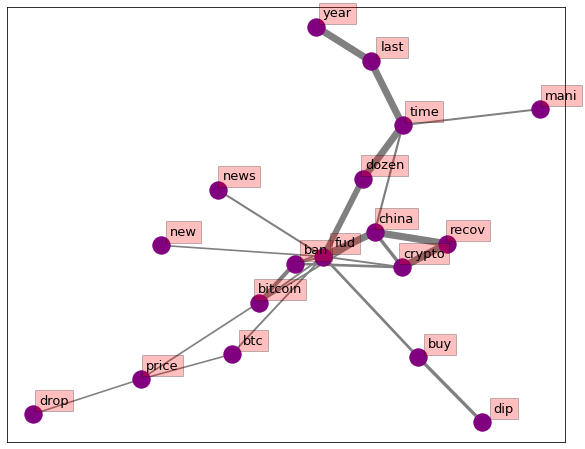

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 7. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  
<img src="./img/pic1.png" style="float:left;" width="50%">  
<img src="./img/pic2.png" style="float:left;" width="25%">

In [47]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [48]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [49]:
bigram_df.head()

,word,word2,n
0,china,fud,1831
1,china,ban,217
2,crypto,recov,143
3,recov,china,143
4,fud,china,142


In [50]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["art_id"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["art_id"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["art_id"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["art_id"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["art_id"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [51]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [52]:
bigram_df

,word,word2,n,cor
0,china,fud,1831,0.604627
1,china,ban,217,0.111999
2,crypto,recov,143,0.385673
3,recov,china,143,0.063997
4,fud,china,142,0.604627
...,...,...,...,...
495,whole,china,4,0.020413
496,break,china,4,0.009413
497,best,buy,4,0.055155
498,fud,becom,4,0.010403


### 7.1 和 china, bitcoin 相關性最高的 15 個詞彙

In [53]:
c_sum = bigram_df[(bigram_df["word"]=="china")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="bitcoin")].sort_values(by=['cor'], ascending = False).head(15)

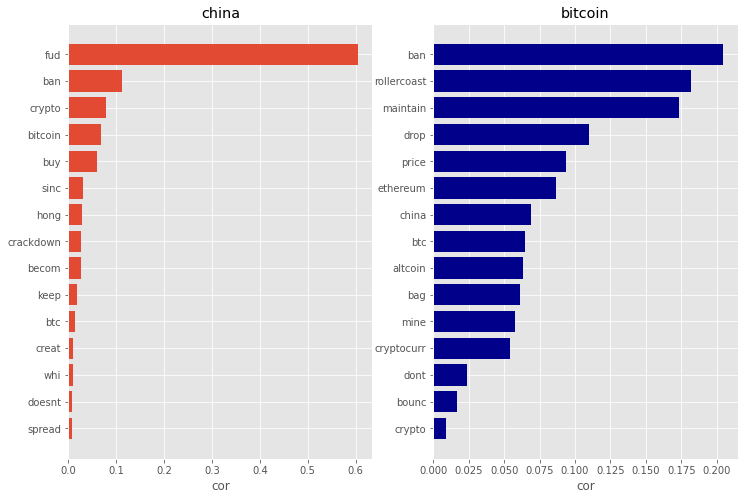

In [54]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('china')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('bitcoin')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()

### 7.2 使用詞彙關係圖畫出相關性大於0.4的組合

In [57]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [58]:
word_cors.head()

,word,word2,n,cor
0,china,fud,1831,0.604627
1,fud,china,142,0.604627
2,last,year,141,0.699337
3,dozen,time,139,0.569566
4,time,last,139,0.530383


In [59]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*8 for w in  g.edges(data=True)]

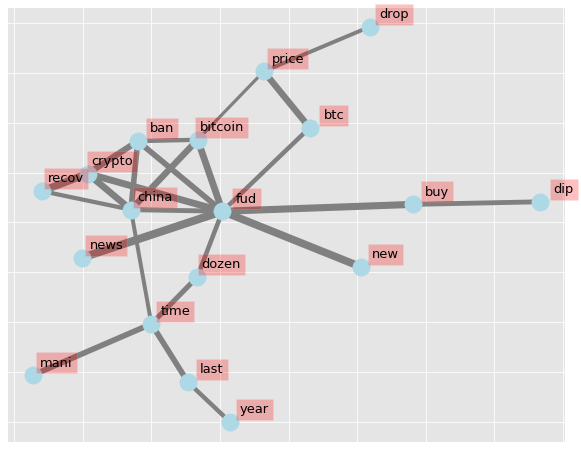

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 9. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章  
<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [63]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["art_id","created_at","text"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.text.apply(getToken).map(' '.join)

In [64]:
# data_cos.head()

,art_id,created_at,text,word
0,0,2021-09-25 08:55:09,cryptan tomskiweb FUD Same old China crackdown...,cryptan tomskiweb fud old china crackdown news...
1,1,2021-09-25 08:51:57,IOHKCharles China is buying thr own FUD nxaa,iohkcharl china buy thr fud nxaa
2,2,2021-09-25 08:51:52,Bitcoin Maintains K Amid the China FUD Cardano...,bitcoin maintain amid china fud cardano onli t...
3,3,2021-09-25 08:50:48,The China FUD is unreal a massive pump maybe c...,china fud unreal massiv pump mayb come
4,4,2021-09-25 08:49:48,china again and again and again im playing thi...,china im play game server year nobodi care chi...


In [65]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

,aaa,aabuzarghaffari,aaron,aav,abaut,abc,abetrad,abil,abit,abl,...,zerohedg,zhusu,zil,ziliqa,zilswap,zo,zolgensma,zone,zoom,zwijberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


,aaa,aabuzarghaffari,aaron,aav,abaut,abc,abetrad,abil,abit,abl,...,zerohedg,zhusu,zil,ziliqa,zilswap,zo,zolgensma,zone,zoom,zwijberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

找和第0篇文章相似的其他文章

In [78]:
print(tfidf.toarray()[0])
cos_df = cosine_similarity(tfidf.toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


<ipython-input-67-6a43be89c380>:5: RuntimeWarning: invalid value encountered in double_scalars
  score = np.dot(vector, i)  / (norm(vector) * norm(i))


In [79]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","art_id","text"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,art_id,text
0,1.000000,0,cryptan tomskiweb FUD Same old China crackdown...
2738,0.408143,2738,danweik tomskiweb FUD About the th China ban t...
452,0.307628,452,davidgokhshtein Old news China banned crypto y...
1040,0.276068,1040,AltcoinDailyio Its not Crypto without China FUD
2567,0.271667,2567,China crypto ban is an old recycled FUD news I...
105,0.254613,105,How many times a year does China ban Bitcoin FUD
2099,0.250223,2099,Lol China FUD never fails
259,0.243659,259,China ban FUD is as old as it gets
2836,0.240904,2836,this China fud thats been happening all year
849,0.223247,849,China has banned mining again Like they did m...
